<a href="https://colab.research.google.com/github/EsbenUrbak/OptionTrading/blob/main/optionTrader_v05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as si
import sympy as sy


#****************PRICING FUNCTIONS*****************************************************************************************************************************#
#Simulator of underlying price
# r is our risk free interest rate to discount by.
# σ is volatility, the annualised standard deviation of a stock's returns.
# T gives us the annualised time to maturity. E.g. for a 30 day option this would be 30/365=0.082...
# S initial price of the underlying asset.

#Generate the MC path 
def generate_asset_price(S,v,r,T):
  Tann = T/365
  return S * np.exp((r - 0.5 * v**2) * Tann + v * np.sqrt(Tann) * random.gauss(0,1.0))

#Price a vanilla option  (option = call, put or straddle)
def euro_vanilla(S, K, v,r,T, option):
  #S: spot price
  #K: strike price
  #T: time to maturity (in time steps)
  #r: interest rate
  #V: volatility of underlying asset
  Tann = T/365
  
  d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * Tann) / (v * np.sqrt(Tann))
  d2 = (np.log(S / K) + (r - 0.5 * v ** 2) * Tann) / (v * np.sqrt(Tann))

  if option == "call":
    result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * Tann) * si.norm.cdf(d2, 0.0, 1.0))
  if option == "put":
    result = (K * np.exp(-r * Tann) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
  if option == "straddle":
    result = (K * np.exp(-r * Tann) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0)) + (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * Tann) * si.norm.cdf(d2, 0.0, 1.0))
  return result

#delta by brute force  
def euro_vanilla_delta(S, K, v,r,T, option):
  up = euro_vanilla(S+0.5, K, v,r,T, option)
  down = euro_vanilla(S-0.5, K, v,r,T, option)
  delta = up - down
  return delta

#Create the asset price path and option price. This will return a pandan wit the asset price, option price and option delta 
def pathAndOptionPrice(S, K, v,r,T, type, stepSize):
  days = 1
  pandaData = pd.DataFrame(columns=['time', 'assetPrice','optionPrice','optionDelta'])
  pandaData.loc[0] = (0,S,euro_vanilla(S,K,v,r,(T-days),type),euro_vanilla_delta(S,K,v,r,(T-days),type))
  
  while days < T:
    sNew = generate_asset_price(pandaData.loc[days-1, 'assetPrice'],v,r,stepSize) 
    optionPrice = euro_vanilla(sNew,K,v,r,(T-days),type)
    optionDelta = euro_vanilla_delta(sNew,K,v,r,(T-days),type)
    pandaData.loc[int(days)] = (days,sNew,optionPrice,optionDelta)
    days += stepSize

  return pandaData

# delta hedging framework to 
def deltaHedging(pathAndOptionPrice, WithGraphs, returnData):
  optionTradingData = pd.DataFrame(columns=['time', 'assetPrice','optionPrice','optionDelta', 'pftDelta', 'cash', 'PV', 'pftValue',"hedgeAmmount"])
  N = len(pathAndOptionPrice)
  S = pathAndOptionPrice.loc[0,'assetPrice']
  optionPrice = pathAndOptionPrice.loc[0,'optionPrice']
  optionDelta = pathAndOptionPrice.loc[0,'optionDelta']
  ptfDelta = optionDelta
  hedgeAmmount = - ptfDelta  # initial delta hedge we do the amount of the option initial
  cash = -optionPrice - hedgeAmmount*S #on day 0 we buy the option and we buy/sell the hedgeMount of the underlying
  PV = optionPrice + hedgeAmmount*S
  pftValue = PV + cash
  optionTradingData.loc[0] = (0, S,optionPrice,optionDelta, 0, cash, PV, pftValue,hedgeAmmount)
  
  for i in range(1,N):
    S = pathAndOptionPrice.loc[i,'assetPrice']
    optionPrice = pathAndOptionPrice.loc[i,'optionPrice']
    optionDelta = pathAndOptionPrice.loc[i,'optionDelta']
    ptfDelta = optionDelta + hedgeAmmount
    cash = cash + ptfDelta*S
    hedgeAmmount = hedgeAmmount - ptfDelta 
    PV = optionPrice + hedgeAmmount*S
    pftValue = PV + cash
    optionTradingData.loc[i] = (i, S,optionPrice,optionDelta, ptfDelta, cash, PV, pftValue,hedgeAmmount)
    
  if WithGraphs == 1:
    optionTradingData.plot(kind='line',x='time',y=['cash','PV'])  
    optionTradingData.plot(kind='line',x='time',y=['pftValue', 'hedgeAmmount'])  
  if returnData ==1:
    return optionTradingData
  return 

# same as above but just returns the final reward
def deltaHedgingReward(pathAndOptionPrice):
  optionTradingData = pd.DataFrame(columns=['time', 'assetPrice','optionPrice','optionDelta', 'pftDelta', 'cash', 'PV', 'pftValue',"hedgeAmmount"])
  N = len(pathAndOptionPrice)
  S = pathAndOptionPrice.loc[0,'assetPrice']
  optionPrice = pathAndOptionPrice.loc[0,'optionPrice']
  optionDelta = pathAndOptionPrice.loc[0,'optionDelta']
  ptfDelta = optionDelta
  hedgeAmmount = - ptfDelta  # initial delta hedge we do the amount of the option initial
  cash = -optionPrice - hedgeAmmount*S #on day 0 we buy the option and we buy/sell the hedgeMount of the underlying
  PV = optionPrice + hedgeAmmount*S
  pftValue = PV + cash
  optionTradingData.loc[0] = (0, S,optionPrice,optionDelta, 0, cash, PV, pftValue,hedgeAmmount)
  
  for i in range(1,N):
    S = pathAndOptionPrice.loc[i,'assetPrice']
    optionPrice = pathAndOptionPrice.loc[i,'optionPrice']
    optionDelta = pathAndOptionPrice.loc[i,'optionDelta']
    ptfDelta = optionDelta + hedgeAmmount
    cash = cash + ptfDelta*S
    #print(S)
    #print(ptfDelta)
    #print(cash)
    hedgeAmmount = hedgeAmmount - ptfDelta 
    PV = optionPrice + hedgeAmmount*S
    pftValue = PV + cash
    optionTradingData.loc[i] = (i, S,optionPrice,optionDelta, ptfDelta, cash, PV, pftValue,hedgeAmmount)
  
  return pftValue




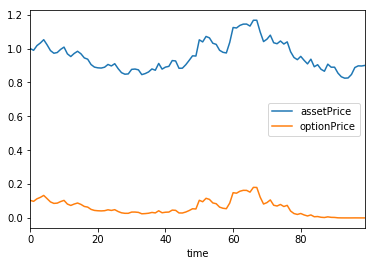

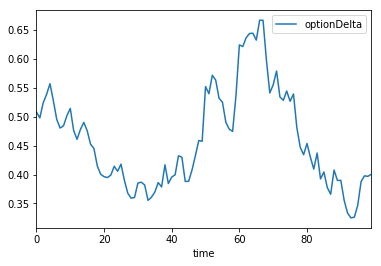

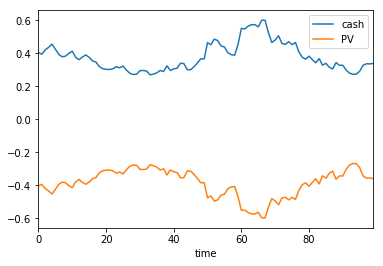

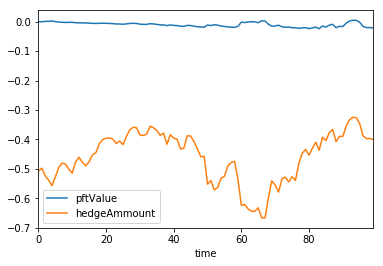

In [ ]:
#**********************************************simulation**********************************************
# To show how the assets and option simulation works
# including graphs showing how the black delta hedging works

S = 1.00 # underlying price
K = 1.00 # option strike price
v = 0.50# vol of 30%
r = 0.00 # rate of 0.0%
T = 100 # days
type = "call"
stepSize = 1 #Days

df = pathAndOptionPrice(S, K, v,r,T, type, stepSize)

df.plot(kind='line',x='time',y=['assetPrice','optionPrice'])
df.plot(kind='line',x='time',y=['optionDelta'])

plt.show()
#print(df)

deltaHedging(df, 1,0)



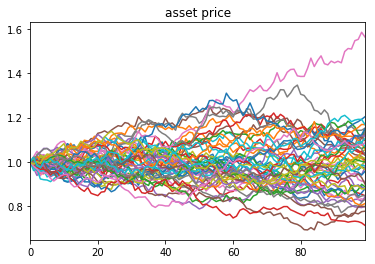

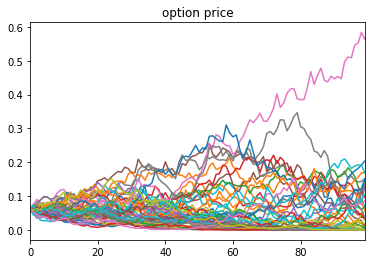

In [ ]:
#********************************************** multi simulation **********************************************
#simply just showing the MC paths using black
S = 1.00 # underlying price
K = 1.00 # option strike price
v = 0.30# vol of 20.76%
r = 0.0000 # rate of 0.14%
T = 100 # days
type = "call"
stepSize = 1 #Days
numberOfPaths = 50
i = 0

asset =  pd.DataFrame()
option = pd.DataFrame()

while i < numberOfPaths:
  nextPath = pathAndOptionPrice(S, K, v,r,T, type, stepSize) 
  asset.insert(i, 'path' + str(i+1),nextPath.iloc[:,1])
  option.insert(i, 'path' + str(i+1),nextPath.iloc[:,2])
  i+=1

asset.plot(title = "asset price", legend = None);
option.plot(title = "option price",legend=None);


In [ ]:
import gym

#***************************************** GYM environment Setup *********************************
#OptionTrader
# Action space: Buy x, Sell y, Nothing
# the oberservation space contains time to expiry, assets price, past asset price, option price and assetsheld 
# reset space: set to initial state: time = 0; reward = 0; asset price = initial price, pnl, optionprice, assethedgevalue, 
# render space: draw graph to show asset price, option price and rewards
#***************************************** GYM environment ***************************************


# some dataframe to pick data while the algo is running. Probably could have been done more sophisticated 
output =  pd.DataFrame(columns=['time','assetPrice','optionPrice','cash','hedgeAmount','profit','done', 'profitBlack','CashBlack','hedgeAmountBlack'])
performance =  pd.DataFrame(columns=['option','reward','rewardDelta'])
blackData = pd.DataFrame(columns=['time', 'assetPrice','optionPrice','optionDelta', 'pftDelta', 'cash', 'PV', 'pftValue',"hedgeAmmount"])



class OptionTrader(gym.Env):
  metadata ={'render.modes':['human']}
  
  def __init__(self):
    super(OptionTrader, self).__init__()
    #get the initial asset and option path
    self.path = pathAndOptionPrice(S, K, v,r,T, type, stepSize) # panda dataframe containing series of the time, asset price and option price
    self.k=0 # could be removed
    # actions of the format %buy, %sell, %hold -> further down i will define what constitute buy and sell (unfortunately at the time of writing Dict is not working for this setup)
    self.action_space = gym.spaces.Box(low=np.array([-1,0]),high=np.array([1,1]),dtype=np.float16)
    # the oberservation space contains time to expiry, assets price, past asset price, option price and assetsheld 
    self.observation_space = gym.spaces.Box(low=0,high=1, shape=(1,5), dtype=np.float16)

  def reset(self):# all the different variables (and we reset them after each game)
    self.current_step = 0    
    self.path=self.path.iloc[:] # empty path (probably not necessary)
    self.path = pathAndOptionPrice(S, K, v,r,T, type, stepSize) # panda dataframe containing series of the time, asset price and option price
    self.assetPrice = self.path.loc[0,"assetPrice"]
    self.optionPrice = self.path.loc[0,"assetPrice"]
    self.assetHedgeAmount = 0 #initially we wont have done any hedges
    self.cash = -self.optionPrice # we buy the option and as such our cash drops
    self.PV = self.optionPrice # our inital portfolio pv
    self.ptfValue = self.cash + self.PV # total value of our holdings
    self.optionExpiry = len(self.path.index) #in days
    self.optionStrike = K  # we can make this a changable variable later as well
    return self._next_observation()
  

  def _next_observation(self): # this generates the "observations" for each time step
      
    if self.current_step == 0:
      i = 0
    else:
      i =-1
      
      #time to exp, asset prce, prior asset price, option price, 
    obs = np.array([self.optionExpiry - self.current_step,self.assetPrice,self.path.loc[self.current_step+i, 'assetPrice'],self.assetHedgeAmount,self.cash])
  
    return obs
   
    
  def step(self, action): # what happens when we take one step
    self._take_action(action)

    reward =0
    done = self.current_step == (len(self.path)-1)
    if done:#only show the reward at the end of the "game"
      reward = -abs(self.PV)  #we want the to end up with zero profit
      rewardDelta = -abs(deltaHedgingReward(self.path))  #this is as a check against black hedging
      self.k +=1
      performance.loc[self.k] = (self.k,reward,rewardDelta)   #I store it here... probably not the most efficient way
    self.current_step +=1 
    if not done:  
      self.optionPrice =  self.path.loc[self.current_step, 'optionPrice']  
      self.assetPrice =  self.path.loc[self.current_step, 'assetPrice']  
    obs = self._next_observation()
    
    return obs, reward, done, {}

  
  def _take_action(self, action):
    action_type = action[0]  # buy, sell or nothing
    amount = action[1] # the size of what we are doing
    
    if action_type  >0.9:  # I set this high to make the decision more discrete
      asset_bought = amount
      #costs = amount * cost_basis # later can add transaction costs
      self.assetHedgeAmount =self.assetHedgeAmount+ asset_bought
      self.cash =self.cash - asset_bought*self.assetPrice # cash decrease by the amount we spend on new hedge
      
    elif action_type  <-0.9: # I set this low to make the decision more discrete
      asset_sold = amount
      #costs = amount * cost_basis # later can add transaction costs
      self.assetHedgeAmount = self.assetHedgeAmount - asset_sold
      self.cash =self.cash+ asset_sold*self.assetPrice # cash increase by the amount we spend on new hedge   

    #update our portfolio value
    self.PV = self.optionPrice + self.assetHedgeAmount*self.assetPrice
    self.ptfValue = self.cash + self.PV          
    
    #simple debug
    #print("newAmount: {}".format(amount))
    #print("totalAmount: {}".format(self.assetHedgeAmount))
    #print("changeInCash: {}".format(self.cash-oldcash))    
    #print("action type: {}".format(action_type))
    #print("amount: {}".format(amount))
    #print("oldAmount: {}".format(self.assetHedgeAmount))
    #print("-----------------------------------")
    
    
  def render(self, mode='human', close=False): # this is a bit of a mess. I Need to clean it up
    if self.current_step >-1:
      profit = self.PV
      assetPrice =self.path.loc[self.current_step, 'assetPrice']
      optionPrice = self.path.loc[self.current_step, 'optionPrice']
      cash = self.cash
      hedgeAmount = self.assetHedgeAmount
      end = self.current_step == (len(self.path)-1)
      
      #if self.current_step ==0:
      blackData = deltaHedging(self.path,0,1)
        #optionTradingData = pd.DataFrame(columns=['time', 'assetPrice','optionPrice','optionDelta', 'pftDelta', 'cash', 'PV', 'pftValue',"hedgeAmmount"])
      k=int(self.current_step)
      #print(blackData)
      
      #blackData.plot(title = "asset price", legend = None);
      profitBlack = blackData.loc[k,"pftValue"]
      cashBlack = blackData.loc[k,"cash"]
      hedgeAmountBlack = blackData.loc[k,"hedgeAmmount"]
      output.loc[int(self.current_step)] = (self.current_step,assetPrice, optionPrice, cash, hedgeAmount, profit,end,profitBlack,cashBlack,hedgeAmountBlack)
      
      
          


In [ ]:
#**********************Multi processing**************************************
def make_env(rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = DummyVecEnv([lambda: OptionTrader()])
        #env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    print("working")
    return _init

In [ ]:
import gym
import json
import datetime as dt
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import set_global_seeds
from stable_baselines import PPO2
import pandas as pd
performance = performance.iloc[0:0]
S = 1.00 # underlying price
K = 1.00 # option strike price
v = 0.30# vol of 30%
r = 0.0 # rate of 0.00%
T = 25 # days

type = "call"
stepSize = 1 #Days
num_cpu = 4

env = DummyVecEnv([lambda: OptionTrader()])
#env =  SubprocVecEnv([make_env(i) for i in range(num_cpu)])#doesnt seem to work. Not sure why?

model = PPO2(MlpPolicy, env, n_steps = T*1000, verbose=1)
#, n_steps = T, , tensorboard_log="./PPO2_trader_tensorboard/"

--------------------------------------
| approxkl           | 0.0029336598  |
| clipfrac           | 0.02551       |
| ep_rewmean         | nan           |
| eplenmean          | nan           |
| explained_variance | 0.00361       |
| fps                | 215           |
| nupdates           | 2             |
| policy_entropy     | 2.8354769     |
| policy_loss        | -0.0026487454 |
| serial_timesteps   | 50000         |
| time_elapsed       | 3.34e-06      |
| total_timesteps    | 50000         |
| value_loss         | 0.28588265    |
--------------------------------------
--------------------------------------
| approxkl           | 0.00017877424 |
| clipfrac           | 1e-05         |
| ep_rewmean         | nan           |
| eplenmean          | nan           |
| explained_variance | -0.144        |
| fps                | 217           |
| nupdates           | 3             |
| policy_entropy     | 2.8298118     |
| policy_loss        | -0.0013895661 |
| serial_timesteps   | 75

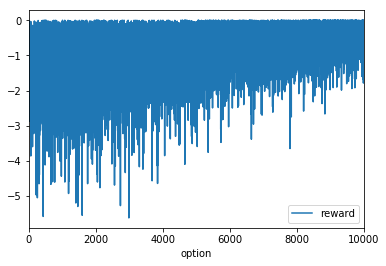

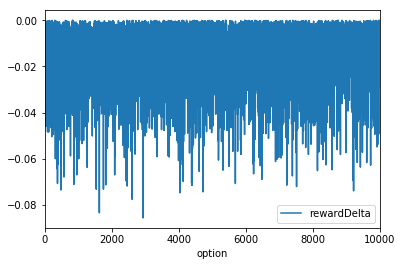

In [ ]:
model.learn(total_timesteps=T*10000)
model.save("OpTrader2")

performance.plot(kind='line',x='option',y='reward')
performance.plot(kind='line',x='option',y='rewardDelta')

--------------------------------------
| approxkl           | 0.0022692755  |
| clipfrac           | 0.01807       |
| ep_rewmean         | nan           |
| eplenmean          | nan           |
| explained_variance | 0.126         |
| fps                | 215           |
| nupdates           | 2             |
| policy_entropy     | 2.7703688     |
| policy_loss        | -0.0025965613 |
| serial_timesteps   | 50000         |
| time_elapsed       | 3.1e-06       |
| total_timesteps    | 50000         |
| value_loss         | 0.021205658   |
--------------------------------------
--------------------------------------
| approxkl           | 0.0017099142  |
| clipfrac           | 0.009339999   |
| ep_rewmean         | nan           |
| eplenmean          | nan           |
| explained_variance | 0.142         |
| fps                | 216           |
| nupdates           | 3             |
| policy_entropy     | 2.7611375     |
| policy_loss        | -0.0018956657 |
| serial_timesteps   | 75

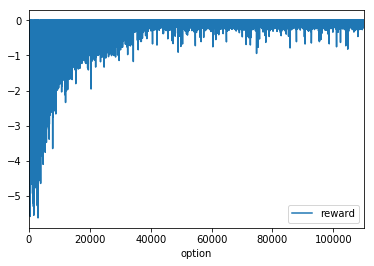

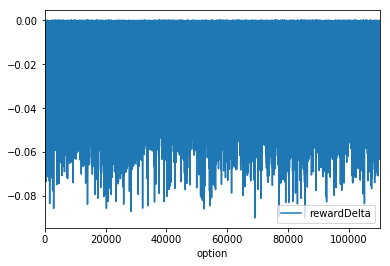

In [ ]:
model.learn(total_timesteps=T*100000)
model.save("OpTrader2")

performance.plot(kind='line',x='option',y='reward')
performance.plot(kind='line',x='option',y='rewardDelta')

[[ 1.3319559 -3.269964 ]]
[[ 1.1102545 -2.546126 ]]
[[ 0.6452923  -0.10198069]]
[[ 2.3617265 -3.2441702]]
[[ 2.76969   -1.6595368]]
[[ 4.2081385 -1.2962577]]
[[ 2.0202057 -1.6558226]]
[[ 1.9601524 -1.1520517]]
[[ 2.0661378 -2.299072 ]]
[[ 2.5692506  -0.46397895]]
[[2.6625917 0.7256967]]
[[ 2.1902363 -2.2980301]]
[[ 2.1101649 -0.9080535]]
[[3.1848755 0.0365974]]
[[ 2.6785812 -0.9811994]]
[[ 1.407088   -0.10926919]]
[[ 3.4042807 -1.3151232]]
[[ 2.7446995  -0.02586547]]
[[2.8239224 1.3693455]]
[[2.457377  1.2264758]]
[[ 1.3611157  -0.23015238]]
[[ 2.480167   -0.04276391]]
[[ 1.1869745 -2.555893 ]]
[[2.0088692 0.9147415]]
   time  assetPrice   optionPrice       cash  hedgeAmount     profit   done  \
1     1    0.998115  2.971968e-02   2.269964    -3.269964  -2.269964  False   
2     2    0.984268  2.259191e-02   4.811290    -5.816090  -5.775406  False   
3     3    0.984832  2.219477e-02   4.811290    -5.816090  -5.702000  False   
4     4    0.957384  1.177144e-02   8.006253    -9.060260 

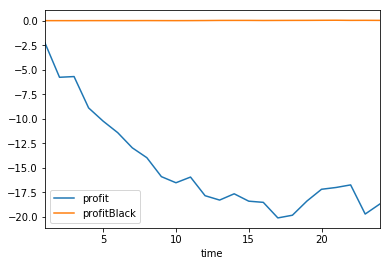

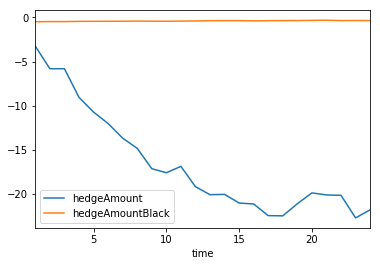

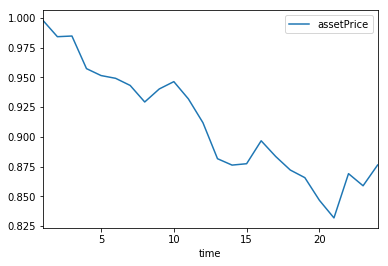

In [ ]:
obs = env.reset()
output =output[0:0]


#deltaHedging =deltaHedging.iloc[0:0]
#print(deltaHedging)
i=0
for i in range(T-1):
  action, _states = model.predict(obs)
  print(action)
  
  #if i == 10:
  obs, rewards, done, info = env.step(action)
  env.render()
  #if i == 80:

#columns=['time','assetPrice','optionPrice','cash','hedgeAmount','profit','done', 'profitBlack','CashBlack','hedgeAmountBlack']  
output.plot(kind='line',x='time',y=['profit','profitBlack'])  
output.plot(kind='line',x='time',y=['hedgeAmount','hedgeAmountBlack'])
output.plot(kind='line',x='time',y=['assetPrice'])
pd.set_option('display.max_columns', 30)
print(output)  

In [ ]:
output.plot(kind='line',x='time',y=['hedgeAmount','hedgeAmountBlack'])

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip 

In [ ]:
LOG_DIR = './PPO2_trader_tensorboard/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


#%tensorboard --logdir ./PPO2_trader_tensorboard/

https://05f1dd19.ngrok.io


In [ ]:
!nvidia-smi

Wed Jul 31 16:03:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |    309MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

SyntaxError: ignored